Plotting the light curve for a single star. [Data](https://github.com/ninahernitschek/advanced_astroinformatics/releases/download/v1.0/_data.zip)

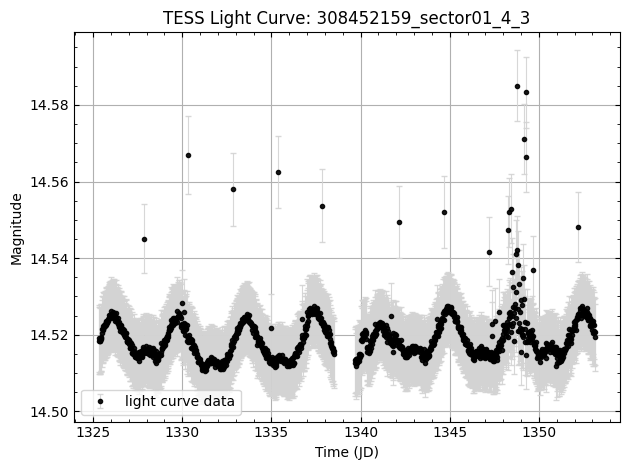

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Input file path
file_path = "/home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_median_after_detrended/_lc_median_after_cbv_detrended_ACV/308452159_sector01_4_3.lc"

# Extract base filename without extension
base_name = os.path.splitext(os.path.basename(file_path))[0]

# Read the data
data_in = pd.read_csv(file_path, sep='\s+', names=['time', 'mag_clean', 'mag', 'magerr'])
tess_lc = data_in.to_records(index=False)

# Plot
plt.errorbar(
    tess_lc['time'],
    tess_lc['mag'],
    yerr=tess_lc['magerr'],
    fmt='o',                 # point markers only
    color='black',           # data point color
    ecolor='lightgray',      # lighter error bar color
    elinewidth=0.8,          # error bar line thickness
    alpha=0.9,               # overall transparency
    markersize=3,
    capsize=2,
    label='light curve data'
)

plt.grid(which='major')
plt.legend(loc='lower left')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Add dynamic labels
plt.xlabel("Time (JD)")
plt.ylabel("Magnitude")
plt.title(f"TESS Light Curve: {base_name}")  # Dynamic title

plt.tight_layout()

# Ensure the output directory exists
output_dir = '/home/devika/PhD/S1/Astroinformatics/Project/lightcurve'
os.makedirs(output_dir, exist_ok=True)

# Save the plot
output_path = os.path.join(output_dir, f"{base_name}.pdf")
plt.savefig(output_path, format='pdf')
plt.show()


Code for generating light curve of all the files and sorting according to the folders

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define base directory and folder names
base_dir = "/home/devika/PhD/S1/Astroinformatics/Project/_data"
folders = {
    "_TESS_lightcurves_raw": ("raw", "mag"),
    "_TESS_lightcurves_median_after_detrended": ("median_after_detrended", "mag_clean"),
    "_TESS_lightcurves_outliercleaned": ("outliercleaned", "mag")
}
output_base = os.path.join(base_dir, "lc_separate")
os.makedirs(output_base, exist_ok=True)

# Summary log
summary = {key: [] for key in folders}

# Loop through each folder type
for folder_name, (output_folder_name, mag_col) in folders.items():
    folder_path = os.path.join(base_dir, folder_name)

    for var_type in os.listdir(folder_path):
        var_type_path = os.path.join(folder_path, var_type)
        if not os.path.isdir(var_type_path):
            continue

        for file in os.listdir(var_type_path):
            if not file.endswith(".lc"):
                continue

            file_path = os.path.join(var_type_path, file)
            base_name = os.path.splitext(file)[0]

            try:
                data = pd.read_csv(file_path, sep='\s+', header=None)

                if folder_name == "_TESS_lightcurves_raw":
                    data.columns = ['time', 'mag', 'magerr']
                elif folder_name == "_TESS_lightcurves_median_after_detrended":
                    data.columns = ['time', 'mag_clean', 'mag_after_cbv', 'magerr']
                elif folder_name == "_TESS_lightcurves_outliercleaned":
                    data.columns = ['time', 'mag', 'magerr']

                # Convert to numeric and drop invalid rows
                data = data.apply(pd.to_numeric, errors='coerce').dropna()

                # Remove known bad values
                data = data[~data[mag_col].astype(str).str.contains(r'\*{5,}|9\.999999')]

                if data.empty:
                    print(f"⚠️ Skipping empty or invalid: {file_path}")
                    continue

                # Plot light curve
                plt.figure(figsize=(9, 5))
                line = plt.errorbar(
                    data['time'], data[mag_col], yerr=data['magerr'],
                    fmt='o', markersize=2, capsize=2,
                    color='black', ecolor='lightgray', alpha=0.8
                )
                plt.legend([line], [f"{folder_name} light curve"])
                plt.xlabel("Time (JD)")
                plt.ylabel("Magnitude")
                plt.title(f"{var_type} - {base_name} ({folder_name})")
                plt.grid(True)
                plt.tight_layout()

                # Output directory
                output_dir = os.path.join(output_base, output_folder_name, var_type)
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, f"{base_name}.pdf")
                plt.savefig(output_path)
                plt.close()

                summary[folder_name].append(file_path)

            except Exception as e:
                print(f"❌ Failed to process {file_path}: {e}")

# Summary report
for folder_name in folders:
    print(f"\n✅ Processed {len(summary[folder_name])} files from {folder_name}")


Code to plot the same light curve of three different file in a single pdf

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "/home/devika/PhD/S1/Astroinformatics/Project/_data"
folders = {
    "_TESS_lightcurves_raw": ("raw", "mag"),
    "_TESS_lightcurves_median_after_detrended": ("median_after_detrended", "mag_after_cbv"),
    "_TESS_lightcurves_outliercleaned": ("outliercleaned", "mag")
}
output_base = os.path.join(base_dir, "Results/lc_separate")
os.makedirs(output_base, exist_ok=True)
three_panel_dir = os.path.join(base_dir, "Results/lc_three_panel")
os.makedirs(three_panel_dir, exist_ok=True)

test_var_types = ['CEP', 'RRAB']

def load_and_clean(file_path, folder_name):
    if folder_name == "_TESS_lightcurves_raw":
        cols = ['time', 'mag', 'magerr']
        sep = r'\s+'
    elif folder_name == "_TESS_lightcurves_outliercleaned":
        cols = ['time', 'mag', 'magerr']
        sep = ','
    elif folder_name == "_TESS_lightcurves_median_after_detrended":
        cols = ['time', 'mag_clean', 'mag_after_cbv', 'magerr']
        sep = r'\s+'
    else:
        raise ValueError(f"Unknown folder: {folder_name}")

    data = pd.read_csv(file_path, sep=sep, header=None, names=cols, comment='#')
    data = data.apply(pd.to_numeric, errors='coerce').dropna()
    mag_cols_to_check = [c for c in data.columns if 'mag' in c]
    for mag_col in mag_cols_to_check:
        data = data[~data[mag_col].astype(str).str.contains(r'\*{5,}|9\.999999')]
    return data

for var_type in test_var_types:
    print(f"\n📁 Processing variable type: {var_type}")
    file_lists = {}

    for folder_name in folders.keys():
        # Use special naming for the median-after-detrended subfolder
        if folder_name == "_TESS_lightcurves_median_after_detrended":
            folder_path = os.path.join(base_dir, folder_name, f"_lc_median_after_cbv_detrended_{var_type}")
        else:
            folder_path = os.path.join(base_dir, folder_name, var_type)

        if not os.path.isdir(folder_path):
            print(f"⚠️ Folder does not exist: {folder_path}")
            file_lists[folder_name] = []
            continue

        file_lists[folder_name] = [f for f in os.listdir(folder_path) if f.endswith(".lc")]
        print(f"✔ Found {len(file_lists[folder_name])} files in {folder_path}")

    # Generate base keys
    def get_base_key(filename, folder):
        if folder == "_TESS_lightcurves_outliercleaned" and filename.endswith("_cleaned.lc"):
            return filename[:-len("_cleaned.lc")]
        if folder == "_TESS_lightcurves_median_after_detrended" and filename.startswith("lc_median_after_cbv_detrended_"):
            return filename[len("lc_median_after_cbv_detrended_"):-len(".lc")]
        if folder == "_TESS_lightcurves_raw":
            return filename[:-len(".lc")]
        return filename[:-len(".lc")]

    base_keys = set()
    for folder_name, files in file_lists.items():
        for f in files:
            base_keys.add(get_base_key(f, folder_name))

    print(f"🔑 Found {len(base_keys)} unique base keys for variable type {var_type}")

    for base_key in list(base_keys)[:3]:  # Try only first 3 for now
        data_dict = {}

        for folder_name, (short_name, mag_col) in folders.items():
            matching_files = [
                f for f in file_lists[folder_name]
                if get_base_key(f, folder_name) == base_key
            ]
            if not matching_files:
                continue
            file_to_use = matching_files[0]

            # Construct correct file path
            if folder_name == "_TESS_lightcurves_median_after_detrended":
                file_path = os.path.join(base_dir, folder_name, f"_lc_median_after_cbv_detrended_{var_type}", file_to_use)
            else:
                file_path = os.path.join(base_dir, folder_name, var_type, file_to_use)

            try:
                data = load_and_clean(file_path, folder_name)
                if not data.empty:
                    data_dict[short_name] = (data, mag_col)
                    print(f"✅ Loaded {folder_name} file for {var_type}/{base_key}: {file_to_use}")
                else:
                    print(f"⚠️ No valid rows after cleaning: {file_to_use}")
            except Exception as e:
                print(f"❌ Failed to load {file_path}: {e}")

        if not data_dict:
            print(f"❌ No valid data found for {var_type}/{base_key}")
            continue

        print(f"📊 Plotting data for: {list(data_dict.keys())}")

        n_panels = len(folders)
        fig, axes = plt.subplots(1, n_panels, figsize=(5 * n_panels, 5), sharey=True)
        if n_panels == 1:
            axes = [axes]

        for ax, (folder_short_name, (data, mag_col)) in zip(axes, data_dict.items()):
            ax.errorbar(
                data['time'], data[mag_col], yerr=data['magerr'],
                fmt='.', markersize=4, capsize=2,
                color='black', ecolor='lightgray', alpha=0.8
            )
            ax.invert_yaxis()
            ax.set_xlabel("Time (JD)")
            ax.set_title(folder_short_name.replace('_', ' ').title())
            ax.grid(True)

        axes[0].set_ylabel("Magnitude")
        plt.suptitle(f"{var_type} - {base_key} (Three-panel Light Curve)")

        out_path = os.path.join(three_panel_dir, f"{var_type}_{base_key}_three_panel.pdf")
        plt.savefig(out_path)
        plt.close()
        print(f"📄 Saved three-panel plot: {out_path}")



📁 Processing variable type: CEP
✔ Found 22 files in /home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_raw/CEP
✔ Found 22 files in /home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_median_after_detrended/_lc_median_after_cbv_detrended_CEP
✔ Found 22 files in /home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_outliercleaned/CEP
🔑 Found 22 unique base keys for variable type CEP
✅ Loaded _TESS_lightcurves_raw file for CEP/271642238_sector01_4_2: 271642238_sector01_4_2.lc
✅ Loaded _TESS_lightcurves_median_after_detrended file for CEP/271642238_sector01_4_2: 271642238_sector01_4_2.lc
✅ Loaded _TESS_lightcurves_outliercleaned file for CEP/271642238_sector01_4_2: 271642238_sector01_4_2_cleaned.lc
📊 Plotting data for: ['raw', 'median_after_detrended', 'outliercleaned']
📄 Saved three-panel plot: /home/devika/PhD/S1/Astroinformatics/Project/_data/Results/lc_three_panel/CEP_271642238_sector01_4_2_three_panel.pdf
✅ Loaded _TESS_lightcurves_ra